# MATH 507 HW1
#### Paul Zhang

## 0. Preperation

In [4]:
import sys
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
import yfinance as yf
import scipy.optimize

In [5]:
print("Env info\nPython={}\nnumpy={}\npandas={}\nmatplotlib={}\nscipy={}\nyfinance={}".format(sys.version, \
        np.__version__, pd.__version__, matplotlib.__version__, scipy.__version__, yf.__version__))

Env info
Python=3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
numpy=1.26.4
pandas=2.2.2
matplotlib=3.9.2
scipy=1.13.1
yfinance=0.2.43


In [6]:
tickers_file = "./TechTickers.csv"

# The following code is not clean enough
# tickers = []
# f = open(tickers_file, "r", encoding = "utf-8-sig")
# for line in csv.reader(f):
#     tickers.append(str(line[0]))
# f.close()
# tickers_str = tickers[0]
# for s in tickers[1:]: 
#     tickers_str = tickers_str + " " + s

# how about this
tickers_list = pd.read_csv(tickers_file, header = None).squeeze("columns").to_list()

start_date = "2013-01-01"
end_date = "2022-01-01"
stock_data = yf.download(tickers_list, start = start_date, end = end_date)

[*********************100%***********************]  67 of 67 completed


### 1. Efficient Frontier

### (a)

In [7]:
num_days = 250
returns_daily = np.log1p(stock_data["Adj Close"].pct_change()).iloc[1:,:]
returns_avg = returns_daily.mean(axis = 0) * num_days
returns_cov = returns_daily.cov(ddof = 1) * num_days
print("Avg Return:\n{}\nEst. Cov Mat:\n{}".format(returns_avg, returns_cov))

Avg Return:
Ticker
AAPL    0.259098
ACN     0.216398
ADBE    0.297217
ADI     0.176171
ADSK    0.223934
          ...   
UI      0.354730
VRSN    0.204270
WDAY    0.181105
WDC     0.067629
ZBRA    0.295267
Length: 67, dtype: float64
Est. Cov Mat:
Ticker      AAPL       ACN      ADBE       ADI      ADSK      AKAM      AMAT  \
Ticker                                                                         
AAPL    0.079348  0.030606  0.043615  0.042492  0.044088  0.027624  0.052258   
ACN     0.030606  0.051374  0.037088  0.035217  0.041216  0.028458  0.041960   
ADBE    0.043615  0.037088  0.086699  0.046989  0.063179  0.038256  0.057093   
ADI     0.042492  0.035217  0.046989  0.083866  0.052201  0.030628  0.075012   
ADSK    0.044088  0.041216  0.063179  0.052201  0.117704  0.039436  0.066051   
...          ...       ...       ...       ...       ...       ...       ...   
UI      0.036262  0.034999  0.043852  0.047224  0.050117  0.042838  0.054605   
VRSN    0.031256  0.029789  0.040

### (b)

In [8]:
N = returns_cov.shape[0]
init =  np.ones(N) / N
min_var = scipy.optimize.minimize(fun = lambda x: x.T@returns_cov@x, x0 = init, constraints = \
                                  {"type": "eq", "fun": lambda x: np.sum(x) - 1})
print("Avg Ret: %.4f\nStd dev: %.4f" %(min_var.x@returns_avg, np.sqrt(min_var.x.T@returns_cov@min_var.x)))
print("Min var weights: {}".format(min_var.x))

Avg Ret: 0.0954
Std dev: 0.1375
Min var weights: [ 0.05933936 -0.03861019 -0.02686987  0.04988188 -0.05505297  0.01383316
 -0.00362028 -0.01354338 -0.02692255  0.07173941  0.04750124  0.02909657
 -0.01219685  0.08682169 -0.01589401  0.18411838 -0.01417618  0.01099056
 -0.04511584 -0.0321523   0.02765647 -0.08404874  0.01452688 -0.03049414
  0.10944724 -0.08140344  0.06839685  0.00113701  0.10125184  0.05014456
  0.01504038 -0.06946901  0.04300053  0.18031834 -0.01740293  0.01184676
 -0.08389039 -0.04390963  0.02619346 -0.01381945  0.10376751 -0.00636297
 -0.0387029  -0.0123201  -0.0396498  -0.01310818  0.01513663  0.05894509
  0.0396046   0.03720453  0.04178673  0.11664529 -0.02253954 -0.05832386
  0.02603213 -0.05778913  0.01920888  0.04423913 -0.01161474  0.09747073
  0.06837607  0.08219111 -0.01731036  0.08006971  0.00741991 -0.02787752
 -0.02618939]


### (c)

In [9]:
gamma = 2
opt_global = scipy.optimize.minimize(fun = lambda x: .5 * gamma * (x.T@returns_cov@x) - x.T@returns_avg, x0 = init, \
                              constraints = {"type": "eq", "fun": lambda x: np.sum(x) - 1})
print("Avg Port. Ret: %.4f\nStd dev: %.4f" %(opt_global.x@returns_avg, np.sqrt(opt_global.x.T@returns_cov@opt_global.x)))

Avg Port. Ret: 3.1435
Std dev: 1.2421


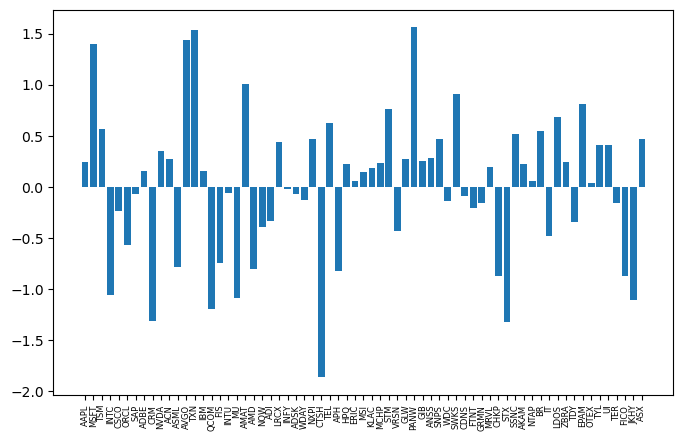

In [10]:
plt.figure(figsize = (8, 5))
plt.bar(tickers_list, opt_global.x)
plt.xticks(rotation = 90, fontsize = 6)
plt.show()

### (d)

In [11]:
returns_std = returns_daily.std(ddof = 1) * np.sqrt(num_days)
opt_robust = scipy.optimize.minimize(fun = lambda x: .5 * gamma * (x.T@returns_cov@x) - x.T@returns_avg + np.abs(x.T)@returns_std, 
                                    x0 = init, constraints = {"type": "eq", "fun": lambda x: np.sum(x) - 1})

print("Robust Avg Ret: %.4f\nStd dev: %.4f" %(opt_robust.x@(returns_avg), np.sqrt(opt_robust.x.T@returns_cov@opt_robust.x)))

Robust Avg Ret: 0.3263
Std dev: 0.2264


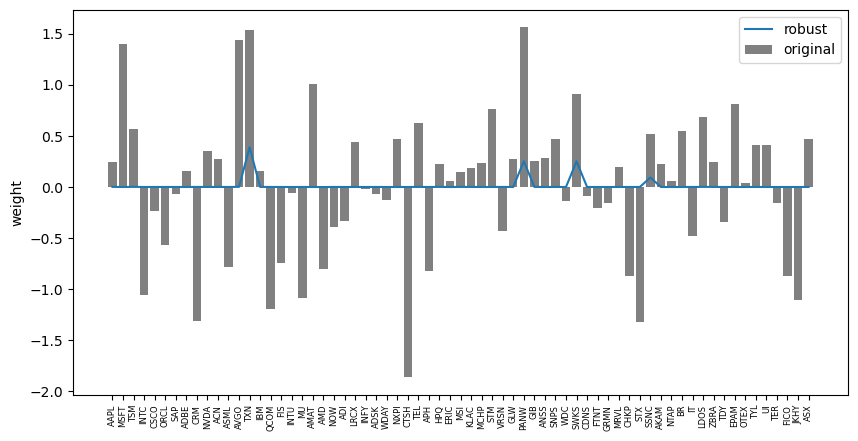

In [12]:
plt.figure(figsize = (10, 5))
plt.plot(tickers_list, opt_robust.x)
plt.bar(tickers_list, opt_global.x, color = "grey")
plt.xticks(rotation = 90, fontsize = 6)
plt.legend(["robust", "original"])
plt.ylabel("weight")
plt.show()

### (e)

In [13]:
mu_0 = np.linspace(0, 2, 100)
sigma = []
for mu in mu_0:
    opt = scipy.optimize.minimize(fun = lambda x: x.T@returns_cov@x, x0 = init, constraints = ({"type": "eq", "fun": \
            lambda x: np.sum(x) - 1}, {"type": "eq", "fun": lambda x: x.T@returns_avg - mu}))
    sigma.append(np.sqrt(opt.x.T@returns_cov@opt.x))

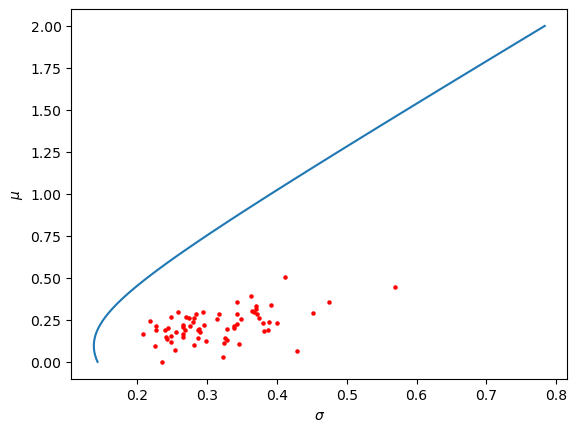

In [14]:
plt.plot(sigma, mu_0)
plt.scatter(np.sqrt(np.diag(returns_cov)), returns_avg, s = 5, c = "red")
plt.xlabel("$\sigma$")
plt.ylabel("$\mu$")
plt.show()

### (f)

In [15]:
rf = .01
opt_mkt = scipy.optimize.minimize(fun = lambda x: (rf - x.T@returns_avg) / np.sqrt(x.T@returns_cov@x), x0 = init,\
                                constraints = {"type": "eq", "fun": lambda x: np.sum(x) - 1})
rp = opt_mkt.x@returns_avg
sigma_p = np.sqrt(opt_mkt.x.T@returns_cov@opt_mkt.x)
print("Tangent Port. Ret: %.4f\nStd dev: %.4f\nSharpe ratio: %.4f" %(rp, sigma_p, rp / sigma_p))

Tangent Port. Ret: 1.4373
Std dev: 0.5605
Sharpe ratio: 2.5645


In [16]:
mu_1 = np.linspace(rf, 2, 100)
w_rf = (rp - mu_1) / (rp - rf)
sigma_mkt = (1 - w_rf) * sigma_p

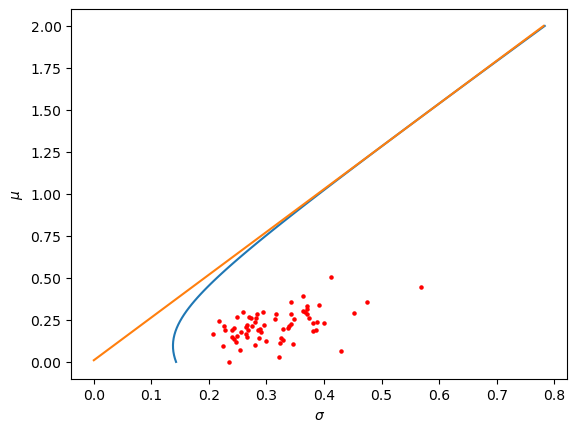

In [17]:
plt.plot(sigma, mu_0)
plt.plot(sigma_mkt, mu_1)
plt.scatter(np.sqrt(np.diag(returns_cov)), returns_avg, s = 5, c = "red")
plt.xlabel("$\sigma$")
plt.ylabel("$\mu$")
plt.show()

## 2. CAPM

### (a)

In [18]:
betas_capm = (returns_cov @ opt_mkt.x) / (opt_mkt.x.T@returns_cov@opt_mkt.x)
print(betas_capm)

Ticker
AAPL    0.174517
ACN     0.144559
ADBE    0.201254
ADI     0.116428
ADSK    0.149848
          ...   
UI      0.241525
VRSN    0.136096
WDAY    0.119926
WDC     0.040358
ZBRA    0.199821
Length: 67, dtype: float64


### (b)

In [19]:
params_reg = pd.DataFrame(columns = ["alpha", "beta", "pval", "R2"])
mkt_portf = np.array(returns_daily @ opt_mkt.x) * num_days
for ticker in tickers_list:
    ols = sm.OLS(returns_daily[ticker] * num_days - rf, sm.add_constant(mkt_portf - rf)).fit()
    params_reg.loc[ticker] = np.hstack([np.array(ols.params), ols.pvalues["x1"], ols.rsquared])
print(params_reg.sort_index())

         alpha      beta          pval        R2
AAPL  0.000012  0.174517  3.308860e-65  0.120568
ACN   0.000070  0.144559  2.900360e-69  0.127773
ADBE -0.000031  0.201254  4.174834e-80  0.146746
ADI  -0.000005  0.116428  1.785913e-27  0.050771
ADSK  0.000057  0.149848  2.837234e-32  0.059925
...        ...       ...           ...       ...
UI    0.000004  0.241525  8.512429e-44  0.081579
VRSN  0.000021  0.136096  1.683797e-52  0.097625
WDAY -0.000064  0.119926  2.817980e-17  0.031081
WDC   0.000026  0.040358  1.210813e-02  0.002777
ZBRA  0.000064  0.199821  3.022593e-50  0.093495

[67 rows x 4 columns]
